In [1]:
import os, sys
import numpy as np
import json
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import seaborn as sns


## Preliminary

In [2]:
torch.manual_seed(12345)
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

na_list = ['A', 'C', 'G', 'T'] #nucleic acids
aa_list = ['R', 'L', 'S', 'A', 'G', 'P', 'T', 'V', 'N', 'D', 'C', 'Q', 'E', 'H', 'I', 'K', 'M', 'F', 'W', 'Y'] #amino acids
NNK_freq = [0.09375]*3 + [0.0625]*5 + [0.03125]*13 #freq of 21 NNK codons including the stop codon
sum_20 = 0.0625*5 + 0.09375*3 + 0.03125*12 #sum of freq without the stop codon
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*12 #normalize freq for 20 codons
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11 + \
        [1- sum([0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11)] 
        #adjust sum to 1 due to numerical issue
aa_dict = dict(zip(aa_list, pvals))
k = 1000

## Dataset

In [3]:
def construct_dataset():
    with open(aptamer_dataset_file, 'r') as f:
        aptamer_data = json.load(f)
    full_dataset = []
    for aptamer in aptamer_data:
        peptides = aptamer_data[aptamer]
        if aptamer == "CTTTGTAATTGGTTCTGAGTTCCGTTGTGGGAGGAACATG": #took out aptamer control
            continue
        for peptide, _ in peptides:
            peptide = peptide.replace("_", "") #removed stop codons
            if "RRRRRR" in peptide: #took out peptide control
                continue
            if len(aptamer) == 40 and len(peptide) == 8: #making sure right length
                full_dataset.append((aptamer, peptide))
    full_dataset = list(set(full_dataset)) #removed duplicates
    return full_dataset

class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, training_set):
        super(TrainDataset, self).__init__() 
        self.training_set = training_set
        
    def __len__(self):
        return len(self.training_set)

    def __getitem__(self, idx):
        aptamer, peptide = self.training_set[idx]
        return aptamer, peptide
    

aptamer_dataset_file = "../data/aptamer_dataset.json"
full_dataset = construct_dataset()
n = len(full_dataset)
training_set = full_dataset[:int(0.8*n)]
test_set = full_dataset[int(0.8*n):]
train_dataset = TrainDataset(training_set)
train_loader = torch.utils.data.DataLoader(train_dataset)

## NN Model

In [4]:
class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        self.cnn_apt_1 = nn.Conv2d(1, 120, (4,4)) #similar to 4-gram
        self.cnn_pep_1 = nn.Conv2d(1, 50, (4,20))
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(4690, 1)
        
    def forward(self, apt, pep):
        apt = self.cnn_apt_1(apt)
        apt = self.relu(apt)
        pep = self.cnn_pep_1(pep)
        pep = self.relu(pep)
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight.data)
        nn.init.zeros_(m.bias.data)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        nn.init.zeros_(m.bias.data)

In [5]:
class DoubleConvNet(nn.Module):
    def __init__(self):
        super(DoubleConvNet, self).__init__()
        self.cnn_apt_1 = nn.Conv2d(1, 1000, (5,4)) #similar to 5-gram
        self.cnn_apt_2 = nn.Conv2d(1000, 100, 1)
        self.cnn_pep_1 = nn.Conv2d(1, 500, (5,20))
        self.cnn_pep_2 = nn.Conv2d(500, 10, 1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(3640, 1)
        
    def forward(self, apt, pep):
        apt = self.cnn_apt_1(apt)
        apt = self.cnn_apt_2(apt)
        apt = self.relu(apt)
        pep = self.cnn_pep_1(pep)
        pep = self.cnn_pep_2(pep)
        pep = self.relu(pep)
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

In [12]:
class MoreComplexNet(nn.Module):
    def __init__(self):
        super(MoreComplexNet, self).__init__()
        self.cnn_apt_1 = nn.Conv2d(1, 500, 1) #similar to 5-gram
        self.cnn_apt_2 = nn.Conv2d(500, 1000, 1)
        self.cnn_apt_3 = nn.Conv2d(1000, 500, 2)
        self.cnn_apt_4 = nn.Conv2d(500, 100, 2)
        self.cnn_apt_5 = nn.Conv2d(100, 10, 2)
        
        self.cnn_pep_1 = nn.Conv2d(1, 250, 1)
        self.cnn_pep_2 = nn.Conv2d(250, 500, 1)
        self.cnn_pep_3 = nn.Conv2d(500, 250, 3)
        self.cnn_pep_4 = nn.Conv2d(250, 100, 2)
        self.cnn_pep_5 = nn.Conv2d(100, 10, 2)
        
        self.relu = nn.ReLU()
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.relu, self.cnn_apt_2, self.relu, self.cnn_apt_3, self.relu, self.cnn_apt_4, self.relu, self.cnn_apt_5)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.relu, self.cnn_pep_2, self.relu, self.cnn_pep_3, self.relu, self.cnn_pep_4, self.relu, self.cnn_pep_5)
        
        
        self.fc1 = nn.Linear(1010, 1)
    
    def forward(self, apt, pep):
        apt = self.cnn_apt(apt)
        apt = self.relu(apt)
        pep = self.cnn_pep(pep)
        pep = self.relu(pep)
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x
        

## Sampling methods

In [7]:
# Sample x from P_X (assume apatamers follow uniform)
def get_x():
    x_idx = np.random.randint(0, 4, 40)
    x = ""
    for i in x_idx:
        x += na_list[i]
    return x

# Sample y from P_y (assume peptides follow NNK)
def get_y():
    y_idx = np.random.choice(20, 7, p=pvals)
    y = "M"
    for i in y_idx:
        y += aa_list[i]
    return y

# S' contains S with double the size of S (domain for Importance Sampling)
# Return S_prime, and S_new (all unseen samples)
def get_S_prime(k):
    S_prime_dict = dict.fromkeys(training_set, 0) #indicator 0 means in the original dataset
    S_new = []
    for _ in range(k):
        pair = (get_x(), get_y())
        S_prime_dict[pair] = 1 #indicator 1 means not in the original dataset
        S_new.append(pair)
    while len(S_new) < 10 * k:
        pair = (get_x(), get_y())
        S_new.append(pair)
    S_prime = [[k,int(v)] for k,v in S_prime_dict.items()]
    random.shuffle(S_prime)
    return S_prime, S_new

# Returns pmf of an aptamer
def get_x_pmf():
    return 0.25**40

# Returns pmf of a peptide
def get_y_pmf(y):
    pmf = 1
    for char in y[1:]: #skips first char "M"
        pmf *= aa_dict[char]
    return pmf


S_prime, S_new = get_S_prime(n) #use for sgd and eval
print("Length of S_new: ", len(S_new))

('Length of S_new: ', 5913090)


## Helper methods

In [8]:
## Takes a peptide and aptamer sequence and converts to one-hot matrix
def one_hot(sequence, seq_type='peptide'):
    if seq_type == 'peptide':
        letters = aa_list
    else:
        letters = na_list
    one_hot = np.zeros((len(sequence), len(letters)))
    for i in range(len(sequence)):
        char = sequence[i]
        for _ in range(len(letters)):
            idx = letters.index(char)
            one_hot[i][idx] = 1
    return one_hot

# Convert a pair to one-hot tensor
def convert(apt, pep): 
    apt = one_hot(apt, seq_type='aptamer') #(40, 4)
    pep = one_hot(pep, seq_type='peptide') #(8, 20)
    apt = torch.FloatTensor(np.reshape(apt, (1, 1, apt.shape[0], apt.shape[1]))).cuda() #(1, 1, 40, 4)
    pep = torch.FloatTensor(np.reshape(pep, (1, 1, pep.shape[0], pep.shape[1]))).cuda() #(1, 1, 8, 20)
    return apt, pep

def update(x, y):
    pmf = get_y_pmf(y)
    x.requires_grad=True
    y.requires_grad=True
    x = x.cuda()
    y = y.cuda()
    out = model(x, y)
    return pmf, out

def generate_loss_samples(k, dataset='train'):
    if dataset == 'train':
        dset = training_set
    elif dataset == 'test':
        dset = test_set
    else:
        dset = S_new
    pairs = []
    for (apt, pep) in dset[:k]:
        x, y = convert(apt, pep)
        pairs.append((x, y))
    return pairs

train_loss_samples = generate_loss_samples(k, 'train')
test_loss_samples = generate_loss_samples(k, 'test')
eval_loss_samples = generate_loss_samples(k, 's_prime')
    
def get_log_out(dataset='train'):
    outs = []
    if dataset == 'train':
        dset = train_loss_samples
    else:
        dset = test_loss_samples
    for (apt, pep) in dset:
        _, out = update(apt, pep)
        outs.append(torch.log(out).cpu().detach().numpy().flatten()[0])
    return np.average(outs)

def get_out_prime():
    outs = []
    for (apt, pep) in eval_loss_samples:
        _, out = update(apt, pep)
        outs.append(out.cpu().detach().numpy().flatten()[0])
    return np.average(outs)

# AUC Plot
def cdf(scores1, scores2): # i is the index
    _, ax = plt.subplots()
    ax.hist(scores1, 100, histtype='step', density=True, cumulative=True, color='red', label='train cdf')
    ax.hist(scores2, 100, histtype='step', density=True, cumulative=True, color='black', label='test cdf')
    ax.legend()
    plt.show()

def histogram(eval_scores, train_scores, test_scores):
    f, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=True)
    plt.xlim(0, 1.1)
    sns.distplot(eval_scores , color="skyblue", label='Eval: not in dataset', ax=axes[0, 0])
    sns.distplot(train_scores , color="gold", label='Train: in dataset', ax=axes[1, 0])
    sns.distplot(test_scores, color='red', label='Test: in the dataset', ax=axes[0, 1])
    axes[0,0].set_title("Eval: not in dataset")
    axes[1,0].set_title("Train: in dataset")
    axes[0, 1].set_title("Test: in dataset")
    plt.show()

def plot_loss(train_loss, test_loss, i, lamb, gamma):
    _, ax = plt.subplots()
    ax.plot(train_loss, 'g', label='Train loss')
    ax.plot(test_loss, 'p', label='Test loss')
    ax.set_title('Loss after ' + str(i) + " iterations, " + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    ax.legend()
    plt.show()

def plot_recall(train_recall, test_recall, i, lamb, gamma):
    _, ax = plt.subplots()
    ax.plot(train_recall, 'b', label='Train recall')
    ax.plot(test_recall, 'y', label='Test recall')
    ax.legend()
    ax.set_title('Recall after ' + str(i) + " iterations, " + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    plt.show()
    

## SGD

In [9]:
def sgd(t=1, #num of iter over the training set
        lamb=1e-1, #hyperparam
        gamma=1e-2): #step size
    optim = SGD(model.parameters(), lr=gamma, momentum=0.1)
    
    train_losses = []
    train_recalls = []
    train_recall_outputs = [] 
    train_cdfs = []

    test_losses = []
    test_recalls = []
    test_recall_outputs = []
    test_cdfs = []

    eval_unknown_outputs = []
    for _ in range(t):
        train_correct = 0
        test_correct = 0
        for i, (apt, pep) in enumerate(tqdm.tqdm(train_loader)):
            # Start timer here
            if i == 0:
                continue
            model.train()
            optim.zero_grad() #reset gradients after update
            
            x, y = convert(apt[0], pep[0]) #sample x,y from training set S
            _, out = update(x, y) #get train score
            log_out = torch.log(out) #take log
            
            
            train_score = out.cpu().detach().numpy().flatten()[0] #get score in float
            if train_score > 0.75:
                train_correct += 1 #contribute to train recall
            train_recall_outputs.append(train_score) #store the train scores
            
            optim.zero_grad() #reset gradients for the second branch
            
            x_prime, y_prime = convert(S_prime[i][0][0], S_prime[i][0][1]) #sample x', y' from S'
            y_pmf, out_prime = update(x_prime, y_prime) #get score'
            out_prime = out_prime*y_pmf*get_x_pmf()*2*n #adjust for IS
            
            const = S_prime[i][1] #indicator
            (lamb*const*out_prime - log_out).backward(retain_graph=True) #backprop
            optim.step() #gradient update
            
            
            if i < int(0.2*n): #check if idx out of range
                model.eval()
                x_test, y_test = convert(test_set[i][0], test_set[i][1]) #sample x,y from test set
                test_score = model(x_test, y_test).cpu().detach().numpy().flatten()[0] #get test score in float
                test_recall_outputs.append(test_score) #store the test scores
                if test_score > 0.75:
                    test_correct += 1 #contribute to test recall
            else:
                test_correct += 1
            #generate 10 unseen examples from S_new as compared 1 example from validate/train for cdfs
            for x, y in S_new[-(10*i+1):9-10*i]:
                x_eval, y_eval = convert(x, y) #generate unseen x'' and y''
                score_eval = model(x_eval, y_eval).cpu().detach().numpy().flatten()[0] #get unknown score
                eval_unknown_outputs.append(score_eval) #store the unknown scores

            if i % 500 == 0:
                out_prime = get_out_prime()
                train_loss = lamb*out_prime - get_log_out('train') #training loss
                test_loss = lamb*out_prime - get_log_out('test') #test loss
                train_losses.append(train_loss)
                test_losses.append(test_loss)
                train_recall = 100*train_correct/i #training recall
                train_recalls.append(train_recall) 
                test_recall = 100*test_correct/i #test recall
                test_recalls.append(test_recall)
                
                train_score = np.asarray(eval_unknown_outputs + train_recall_outputs) #combine train and unknown scores
                test_score = np.asarray(eval_unknown_outputs + test_recall_outputs) #combibne test and unknown scores
                train_cdf = np.sum(np.cumsum(train_score), dtype=float)/(np.sum(train_score)*len(train_score)) #train cdf
                test_cdf = np.sum(np.cumsum(test_score), dtype=float)/(np.sum(test_score)*len(test_score)) #test cdf
                train_cdfs.append(train_cdf)
                test_cdfs.append(test_cdf)
                
                
            if i % 10000 == 0:
                #T = [j for j in range(501, i, 10000//500)]
                plot_recall(train_recalls, test_recalls, i, lamb, gamma)
                plot_loss(train_losses, test_losses, i, lamb, gamma)
                print("Train cdfs: ", train_cdfs[-2])
                print("Test cdfs: ", test_cdfs[-2])
                print("Train scores unkown: ", train_score[:2])
                print("Train scores train: ", train_score[-2:])
                print("Test scores unkown: ", test_score[:2])
                print("Test scores train: ", test_score[-2:])
                cdf(train_score, test_score)
                # Create a scatter plot where we map train recall outputs, test recall outputs, eval outputs
                histogram(eval_unknown_outputs[-100000:], train_recall_outputs[-10000:], test_recall_outputs[-10000:])
                
                


## Hyperparameter tuning

In [10]:
gammas = [1e-5]
lambdas = [0.5] #[1, 1e-3, 10, 1e-5]

  2%|▏         | 9998/473047 [06:59<4:20:29, 29.63it/s] 

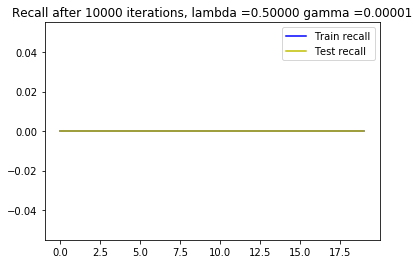

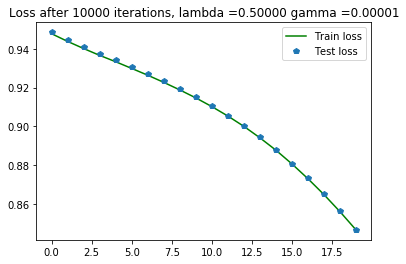

('Train cdfs: ', 0.49170351923663824)
('Test cdfs: ', 0.4917160558065107)
('Train scores unkown: ', array([0.51556057, 0.50298727], dtype=float32))
('Train scores train: ', array([0.5743725, 0.5693672], dtype=float32))
('Test scores unkown: ', array([0.51556057, 0.50298727], dtype=float32))
('Test scores train: ', array([0.5611191 , 0.58905435], dtype=float32))


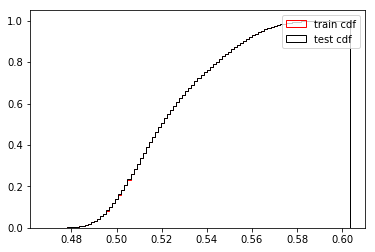

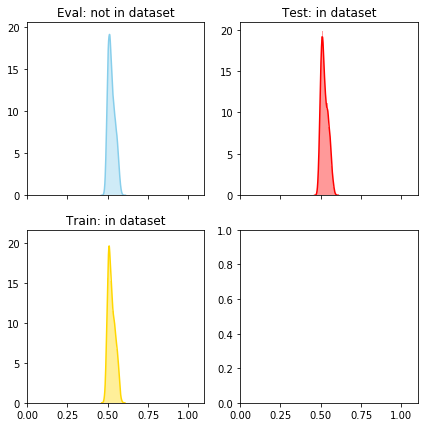

  4%|▍         | 19998/473047 [14:05<4:17:04, 29.37it/s] 

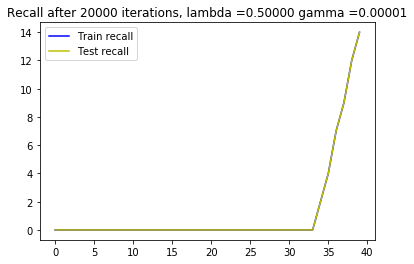

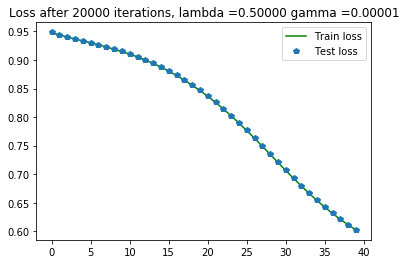

('Train cdfs: ', 0.46314881879073355)
('Test cdfs: ', 0.4631580762274537)
('Train scores unkown: ', array([0.51556057, 0.50298727], dtype=float32))
('Train scores train: ', array([0.8307945, 0.8250719], dtype=float32))
('Test scores unkown: ', array([0.51556057, 0.50298727], dtype=float32))
('Test scores train: ', array([0.8210504 , 0.82714677], dtype=float32))


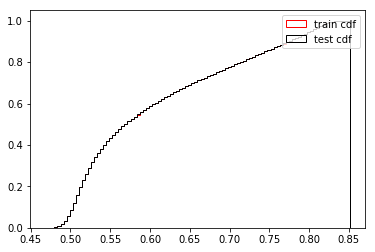

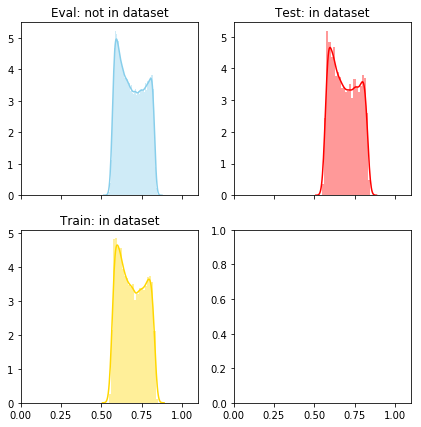

  6%|▋         | 29999/473047 [21:11<4:10:24, 29.49it/s] 

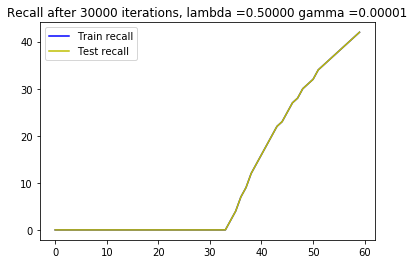

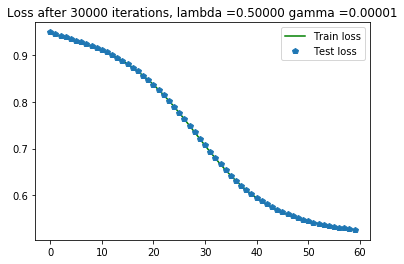

('Train cdfs: ', 0.44517117193310335)
('Test cdfs: ', 0.4451760664256807)
('Train scores unkown: ', array([0.51556057, 0.50298727], dtype=float32))
('Train scores train: ', array([0.94807905, 0.9503124 ], dtype=float32))
('Test scores unkown: ', array([0.51556057, 0.50298727], dtype=float32))
('Test scores train: ', array([0.9529018, 0.9565668], dtype=float32))


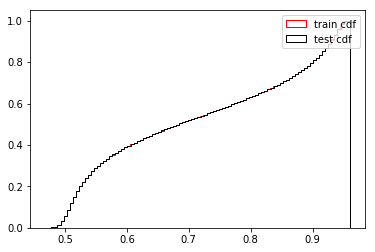

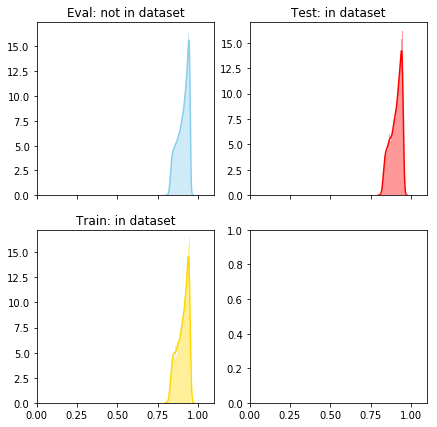

  8%|▊         | 40000/473047 [28:23<4:31:06, 26.62it/s] 

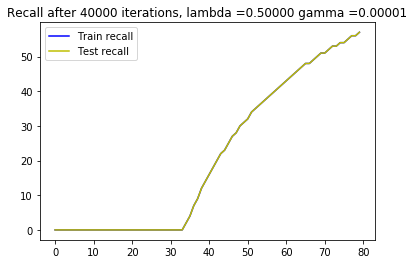

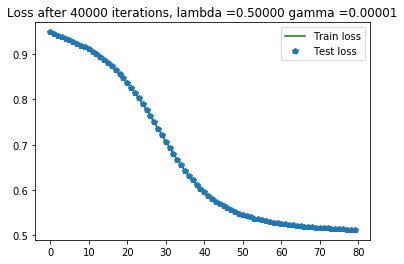

('Train cdfs: ', 0.4448902391094202)
('Test cdfs: ', 0.44489360418666063)
('Train scores unkown: ', array([0.51556057, 0.50298727], dtype=float32))
('Train scores train: ', array([0.9792498, 0.9751941], dtype=float32))
('Test scores unkown: ', array([0.51556057, 0.50298727], dtype=float32))
('Test scores train: ', array([0.97567004, 0.9770519 ], dtype=float32))


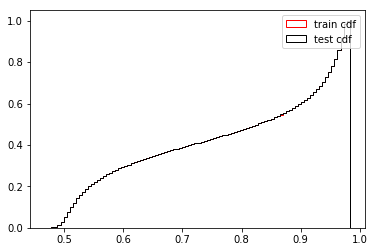

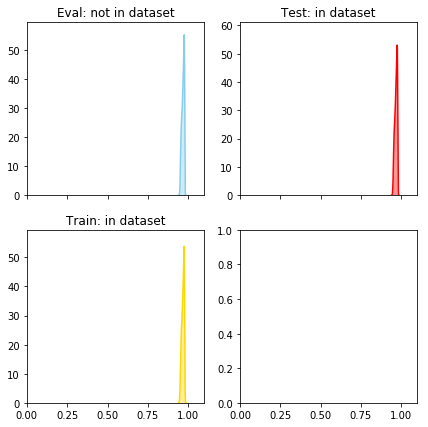

 11%|█         | 49999/473047 [35:33<3:58:19, 29.58it/s] 

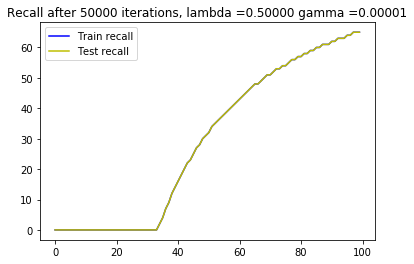

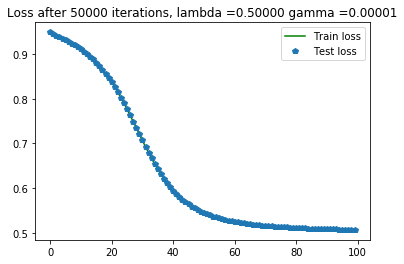

('Train cdfs: ', 0.4487981576140698)
('Test cdfs: ', 0.44880076628062315)
('Train scores unkown: ', array([0.51556057, 0.50298727], dtype=float32))
('Train scores train: ', array([0.9861173, 0.9861373], dtype=float32))
('Test scores unkown: ', array([0.51556057, 0.50298727], dtype=float32))
('Test scores train: ', array([0.9861444 , 0.98621595], dtype=float32))


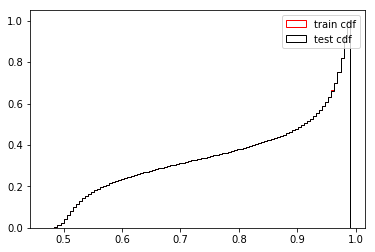

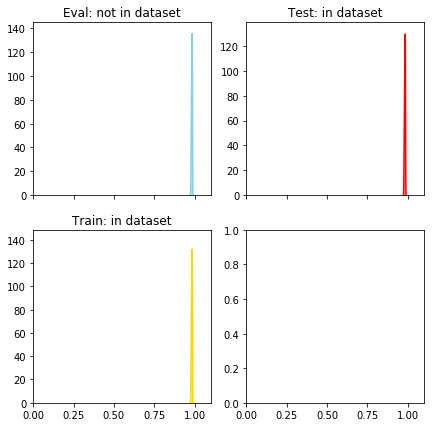

 13%|█▎        | 60000/473047 [42:50<3:53:24, 29.49it/s] 

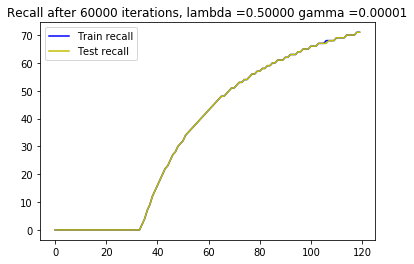

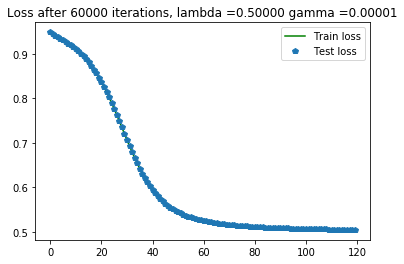

('Train cdfs: ', 0.45379319168241083)
('Test cdfs: ', 0.4537953847637891)
('Train scores unkown: ', array([0.51556057, 0.50298727], dtype=float32))
('Train scores train: ', array([0.9917424 , 0.99177414], dtype=float32))
('Test scores unkown: ', array([0.51556057, 0.50298727], dtype=float32))
('Test scores train: ', array([0.99166334, 0.98995006], dtype=float32))


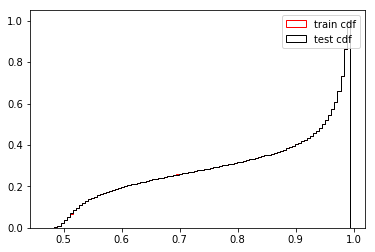

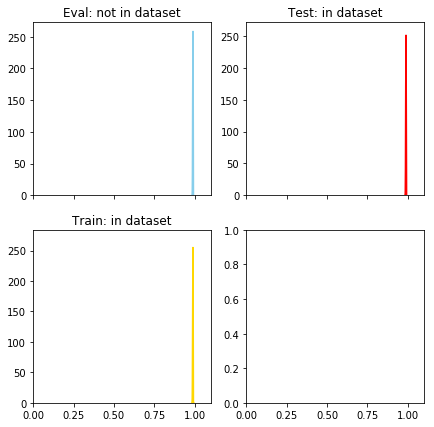

 15%|█▍        | 70000/473047 [49:59<3:46:29, 29.66it/s] 

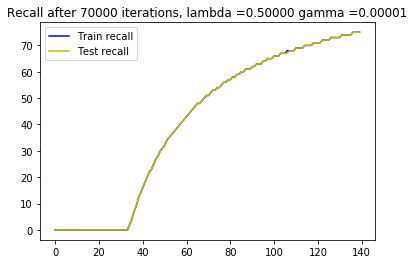

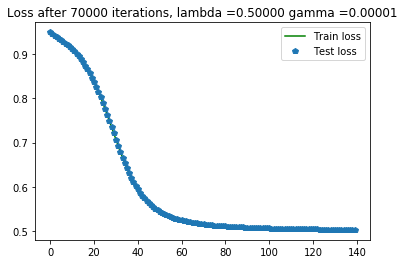

('Train cdfs: ', 0.458381113978751)
('Test cdfs: ', 0.4583830773556694)
('Train scores unkown: ', array([0.51556057, 0.50298727], dtype=float32))
('Train scores train: ', array([0.9940848 , 0.99273634], dtype=float32))
('Test scores unkown: ', array([0.51556057, 0.50298727], dtype=float32))
('Test scores train: ', array([0.9925141, 0.9934077], dtype=float32))


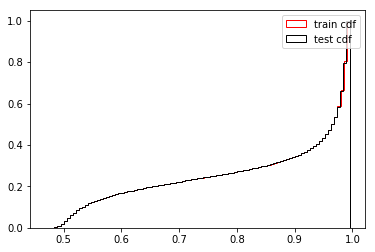

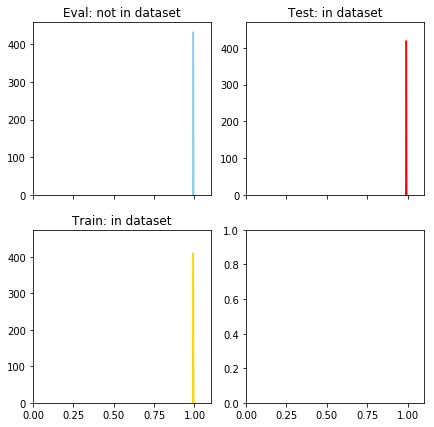

 16%|█▌        | 76604/473047 [54:45<3:44:06, 29.48it/s] 

In [ ]:
for g in range(len(gammas)):
    for l in range(len(lambdas)):
        model = MoreComplexNet()
        model.apply(weights_init)
        model.cuda()
        
        sgd(t=5, gamma=gammas[g], lamb=lambdas[l])